In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os,sys,glob,json,pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc

import scipy.stats as stats

import healpy as hp

import astropy.constants as const
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle

current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index('Research')
top_directory = "/".join(splt_path[0:top_path_idx+1])

hasasia_path = top_directory + '/hasasia/'

sys.path.insert(0,hasasia_path)

import hasasia.sensitivity as hassen
import hasasia.sim as hassim
import hasasia.skymap as hassky

In [3]:
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.figsize'] = [5,3]
mpl.rcParams['text.usetex'] = True
mpl.rc('font',**{'family':'serif','serif':['Times New Roman'],'size':14})

In [4]:
top_dir = '/Users/andrewkaiser/Documents/GradSchool/Research/nanograv'
pta_sim_dir = top_dir + '/pta_sim/pta_sim/'
save_dir = top_dir + '/Figures/'


sys.path.insert(0,pta_sim_dir)
import noise


In [5]:
noise_11yr_dir = top_dir + '/NANOGrav/BackgroundInjections/nano11/noisefiles_new/'
noise_11yr = sorted(glob.glob(noise_11yr_dir+'*.txt'))
print(len(noise_11yr))

45


In [6]:
psrlist_11yr_file = top_dir + '/NANOGrav/BackgroundInjections/nano11/psrlist_Tg3yr.txt'
encoding = 'utf-8'
psr_list_bytes = np.loadtxt(psrlist_11yr_file,dtype='S42')
psr_list = []
for psr in psr_list_bytes:
    psr_list.append(psr.decode(encoding))
print(len(psr_list))

34


In [7]:
psrlis_ipta_file = 'IPTA_pulsars.txt'
psr_list_ipta = np.loadtxt(psrlis_ipta_file,dtype='str')

In [8]:
#Add IPTA pulsars
for psr in psr_list:
    if psr not in psr_list_ipta:
        psr_list_ipta = np.append(psr_list_ipta,psr)

In [9]:
def get_psrname(file,name_sep='_'):
    return file.split('/')[-1].split(name_sep)[0]

In [10]:
noise_11yr = [f for f in noise_11yr if get_psrname(f,name_sep='_') in psr_list]
len(noise_11yr)

34

In [11]:
noiseparams_11yr = {}
for nf in noise_11yr:
    noiseparams_11yr.update(noise.get_noise_from_file(nf))

In [12]:
rn_amps=[]
rn_alphas=[]
for psr in psr_list:
    rn_amps.append(10**noiseparams_11yr[psr+'_red_noise_log10_A'])
    rn_alphas.append((noiseparams_11yr[psr+'_red_noise_gamma']-3)/(-2))

In [13]:
def get_psr_sky_coords(psr_list):
    coord = []
    for i in range(len(psr_list)):
        if 'J' in psr_list[i]:
            if '+' in psr_list[i]:
                #if '1713' not in psr_list[i]:
                a = psr_list[i].split('J')[1]
                b = a.split('+')[0]
                c = a.split('+')[1]
                ra = (b[0:2]+'h'+b[2:4]+'m00s')
                dec = ('+'+c[0:2]+'d'+c[2:4]+'m00s')
                coord.append(SkyCoord(ra, dec, frame='icrs'))

            else:
                a = psr_list[i].split('J')[1]
                b = a.split('-')[0]
                c = a.split('-')[1]
                ra = (b[0:2]+'h'+b[2:4]+'m00s')
                dec = ('-'+c[0:2]+'d'+c[2:4]+'m00s')            
                coord.append(SkyCoord(ra, dec, frame='icrs'))
        else:
            if '+' in psr_list[i]:
                a = psr_list[i].split('B')[1]
                b = a.split('+')[0]
                c = a.split('+')[1]
                ra = (b[0:2]+'h'+b[2:4]+'m00s')
                dec = ('+'+c[0:2]+'d'+'00m00s')
                coord.append(SkyCoord(ra, dec, frame='fk4'))
            else:
                a = psr_list[i].split('B')[1]
                b = a.split('-')[0]
                c = a.split('-')[1]
                ra = (b[0:2]+'h'+b[2:4]+'m00s')
                dec = ('-'+c[0:2]+'d'+'00m00s')
                coord.append(SkyCoord(ra, dec, frame='fk4'))
    return coord

In [14]:
coord = get_psr_sky_coords(psr_list)
coord_ipta = get_psr_sky_coords(psr_list_ipta)

In [15]:
phis = np.array([c.ra.radian for c in coord])
thetas = np.array([np.pi/2 - c.dec.radian for c in coord])

phis_ipta = np.array([c.ra.radian for c in coord_ipta])
thetas_ipta = np.array([np.pi/2 - c.dec.radian for c in coord_ipta])

In [16]:
sigmas=np.array([0.361, 0.691, 0.454,
                 0.422, 0.178, 1.07,
                 0.323, 0.672, 0.23,
                 0.199, 0.426, 3.31,
                 0.108, 0.52, 0.128,
                 0.842, 3.59, 0.239,
                 0.809, 3.65, 0.148,
                 0.544, 0.322, 0.229,
                 0.57, 0.352, 0.377,
                 0.257, 0.11, 0.12,
                 0.968, 1.33, 1.07,
                 0.271])*u.us.to('s')

In [17]:
header = 'Row order: phis, thetas, sigmas, RN_amps, RN_alphas'
#np.savetxt(top_dir + '/params_11yr.txt',[phi,theta,sigmas.value,amps,alphas],header=header)

In [18]:
T_obs = 11.5*u.yr#[11.5,14.5,20.]*u.yr#,25.,30.]*u.yr
sigma = 100*u.ns.to('s')*u.s # 100 ns
cadence = 23/u.yr #number of observations/yr
f_min = cadence.to('1/s')/2. #nyquist frequency

In [19]:
#Use the healpy functions to get the sky coordinates
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)
IPIX = np.arange(NPIX)
theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)

In [20]:
def make_hasasia_sensitivity_thing(T_obs,cadence,sigmas,phis,thetas,rn_amps,rn_alphas,SkyAvg=False):
    Tspan = T_obs.to('s') #Tspan in seconds
    #Simulate a set of identical pulsars, with different sky positions.
    freqs = np.logspace(np.log10(1/(5*Tspan.value)),np.log10(f_min.value),500)

    psrs = hassim.sim_pta(timespan=T_obs.value, cad=cadence.value, sigma=sigmas,
                    phi=phis, theta=thetas, A_rn = rn_amps, alpha=rn_alphas, freqs = freqs)
    spectra = []
    for p in psrs:
        sp = hassen.Spectrum(p, freqs=freqs)
        sp.NcalInv
        spectra.append(sp)
        
    if SkyAvg:
        #make deterministic pta
        return hassen.DeterSensitivityCurve(spectra)
    else:
        return hassky.SkySensitivity(spectra,theta_gw, phi_gw)

In [21]:
def strain_plaw(A, alpha, freqs):
    S_h_gwb = hassen.S_h(A, alpha, freqs)
    h_c_gwb = np.sqrt(freqs*S_h_gwb)

    return h_c_gwb

In [22]:
background_amps_1 = [4e-16]*len(rn_amps)
background_alphas_1 = [-2/3.]*len(rn_alphas)
background_amps_2 = [5e-15]*len(rn_amps)
background_alphas_2 = [-1/4.]*len(rn_alphas)

In [33]:
multiple_rn_alphas_1 = []
multiple_rn_alphas_2 = []
multiple_rn_alphas_3 = []
multiple_rn_amps_1 = []
multiple_rn_amps_2 = []
multiple_rn_amps_3 = []
for i in range(len(rn_amps)):
    multiple_rn_amps_1.append([rn_amps[i],background_amps_1[i]])
    multiple_rn_alphas_1.append([rn_alphas[i],background_alphas_1[i]])
    multiple_rn_amps_2.append([rn_amps[i],background_amps_1[i],background_amps_2[i]])
    multiple_rn_alphas_2.append([rn_alphas[i],background_alphas_1[i],background_amps_2[i]])
    if i%2 == 0:
        multiple_rn_amps_3.append([rn_amps[i],background_amps_1[i],3e-15])
        multiple_rn_alphas_3.append([rn_alphas[i],background_alphas_1[i],-1.])
    else:
        multiple_rn_amps_3.append([rn_amps[i],background_amps_1[i]])
        multiple_rn_alphas_3.append([rn_alphas[i],background_alphas_1[i]])

In [34]:
print(len(multiple_rn_amps_3))
print(multiple_rn_amps_3[0][0])
print(multiple_rn_amps_3[1])
print(len(rn_alphas))

34
3.5628701940455306e-15
[1.069547310566159e-14, 4e-16]
34


In [35]:
sky_avg_1 = make_hasasia_sensitivity_thing(T_obs,cadence,sigmas,phis,thetas,
                                           rn_amps,rn_alphas,SkyAvg=True)

In [36]:
sky_avg_2 = make_hasasia_sensitivity_thing(T_obs,cadence,sigmas,phis,thetas,
                                           multiple_rn_amps_1,multiple_rn_alphas_1,SkyAvg=True)

In [37]:
sky_avg_3 = make_hasasia_sensitivity_thing(T_obs,cadence,sigmas,phis,thetas,
                                           multiple_rn_amps_2,multiple_rn_alphas_2,SkyAvg=True)

In [38]:
sky_avg_4 = make_hasasia_sensitivity_thing(T_obs,cadence,sigmas,phis,thetas,
                                           multiple_rn_amps_3,multiple_rn_alphas_3,SkyAvg=True)

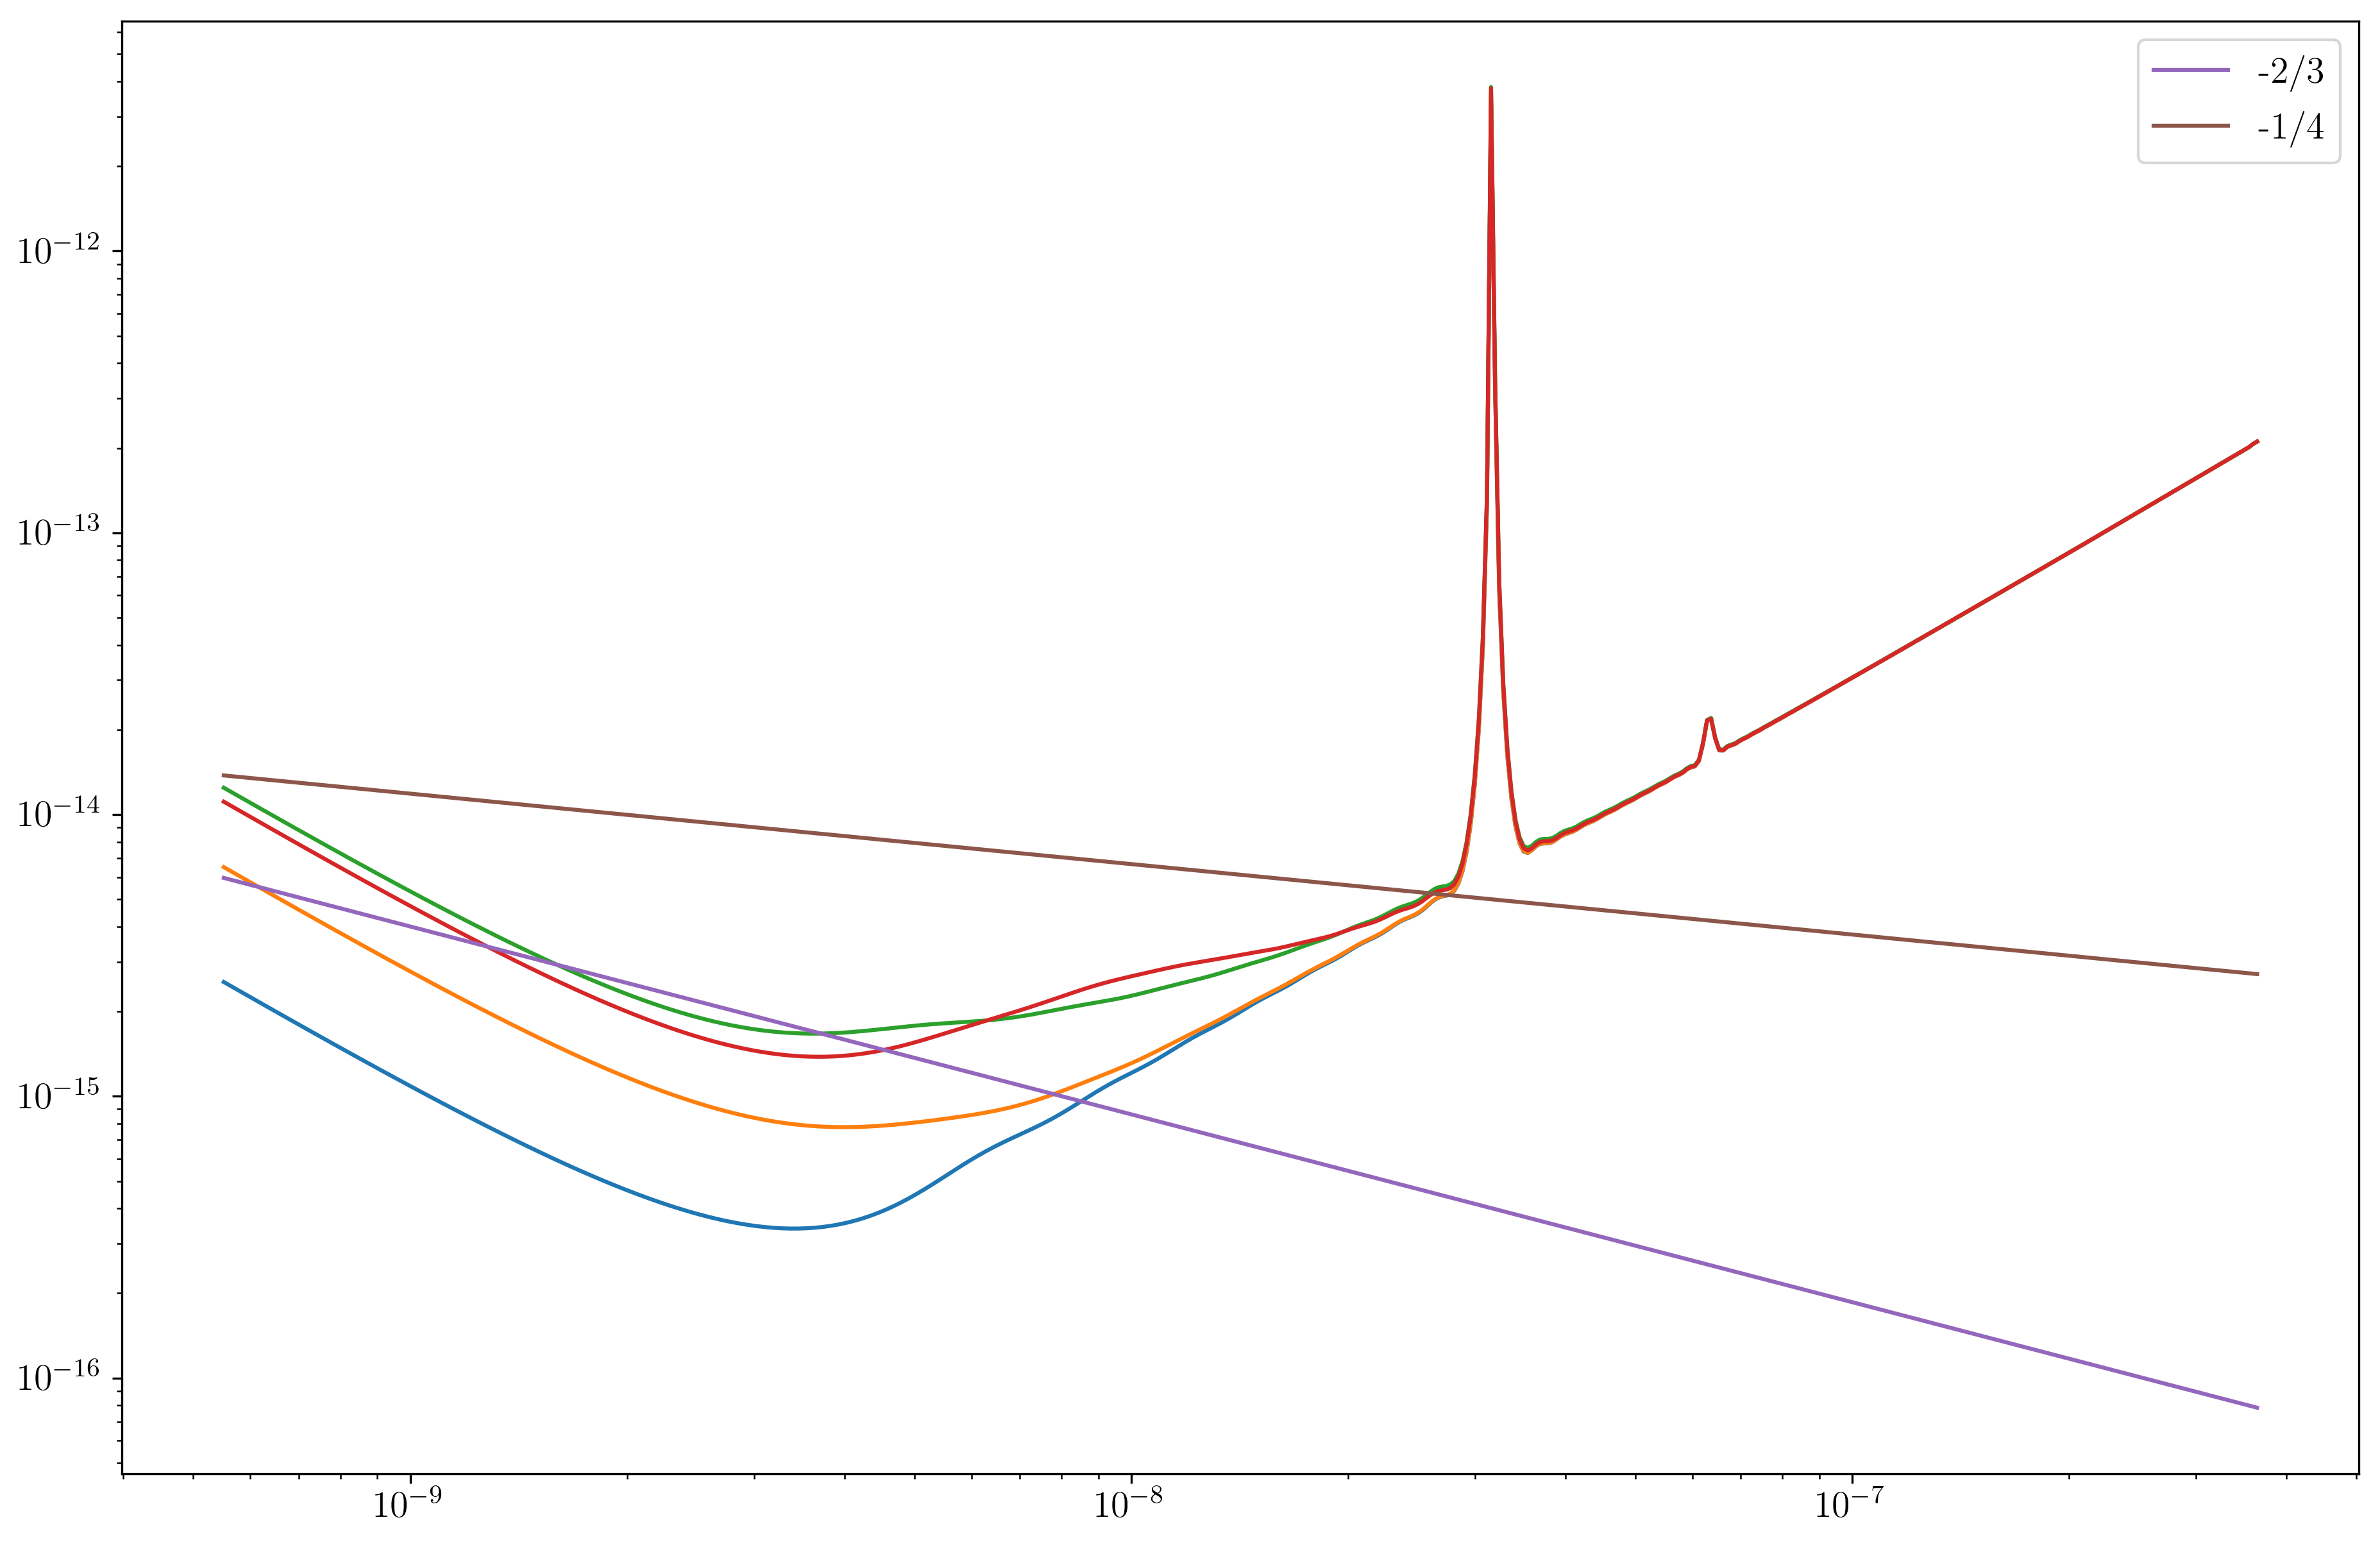

In [41]:
plt.figure(figsize=(15,10))
#plt.loglog(curv.freqs,curv.h_c)
# Make a power-law spectrum using the given amplitude and calculate the SNR
plt.loglog(sky_avg_1.freqs,sky_avg_1.h_c)
plt.loglog(sky_avg_2.freqs,sky_avg_2.h_c)
plt.loglog(sky_avg_3.freqs,sky_avg_3.h_c)
plt.loglog(sky_avg_4.freqs,sky_avg_4.h_c)
plt.loglog(sky_avg_2.freqs,strain_plaw(background_amps_1[0],background_alphas_1[0],sky_avg_2.freqs),label=r'-2/3')
plt.loglog(sky_avg_3.freqs,strain_plaw(background_amps_2[0],background_alphas_2[0],sky_avg_3.freqs),label=r'-1/4')
plt.legend()
# plt.ylim(4e-16,1e-15)
plt.show()

In [30]:
sky_map = make_hasasia_sensitivity_thing(T_obs,cadence,sigmas,phis,thetas,rn_amps,rn_alphas)

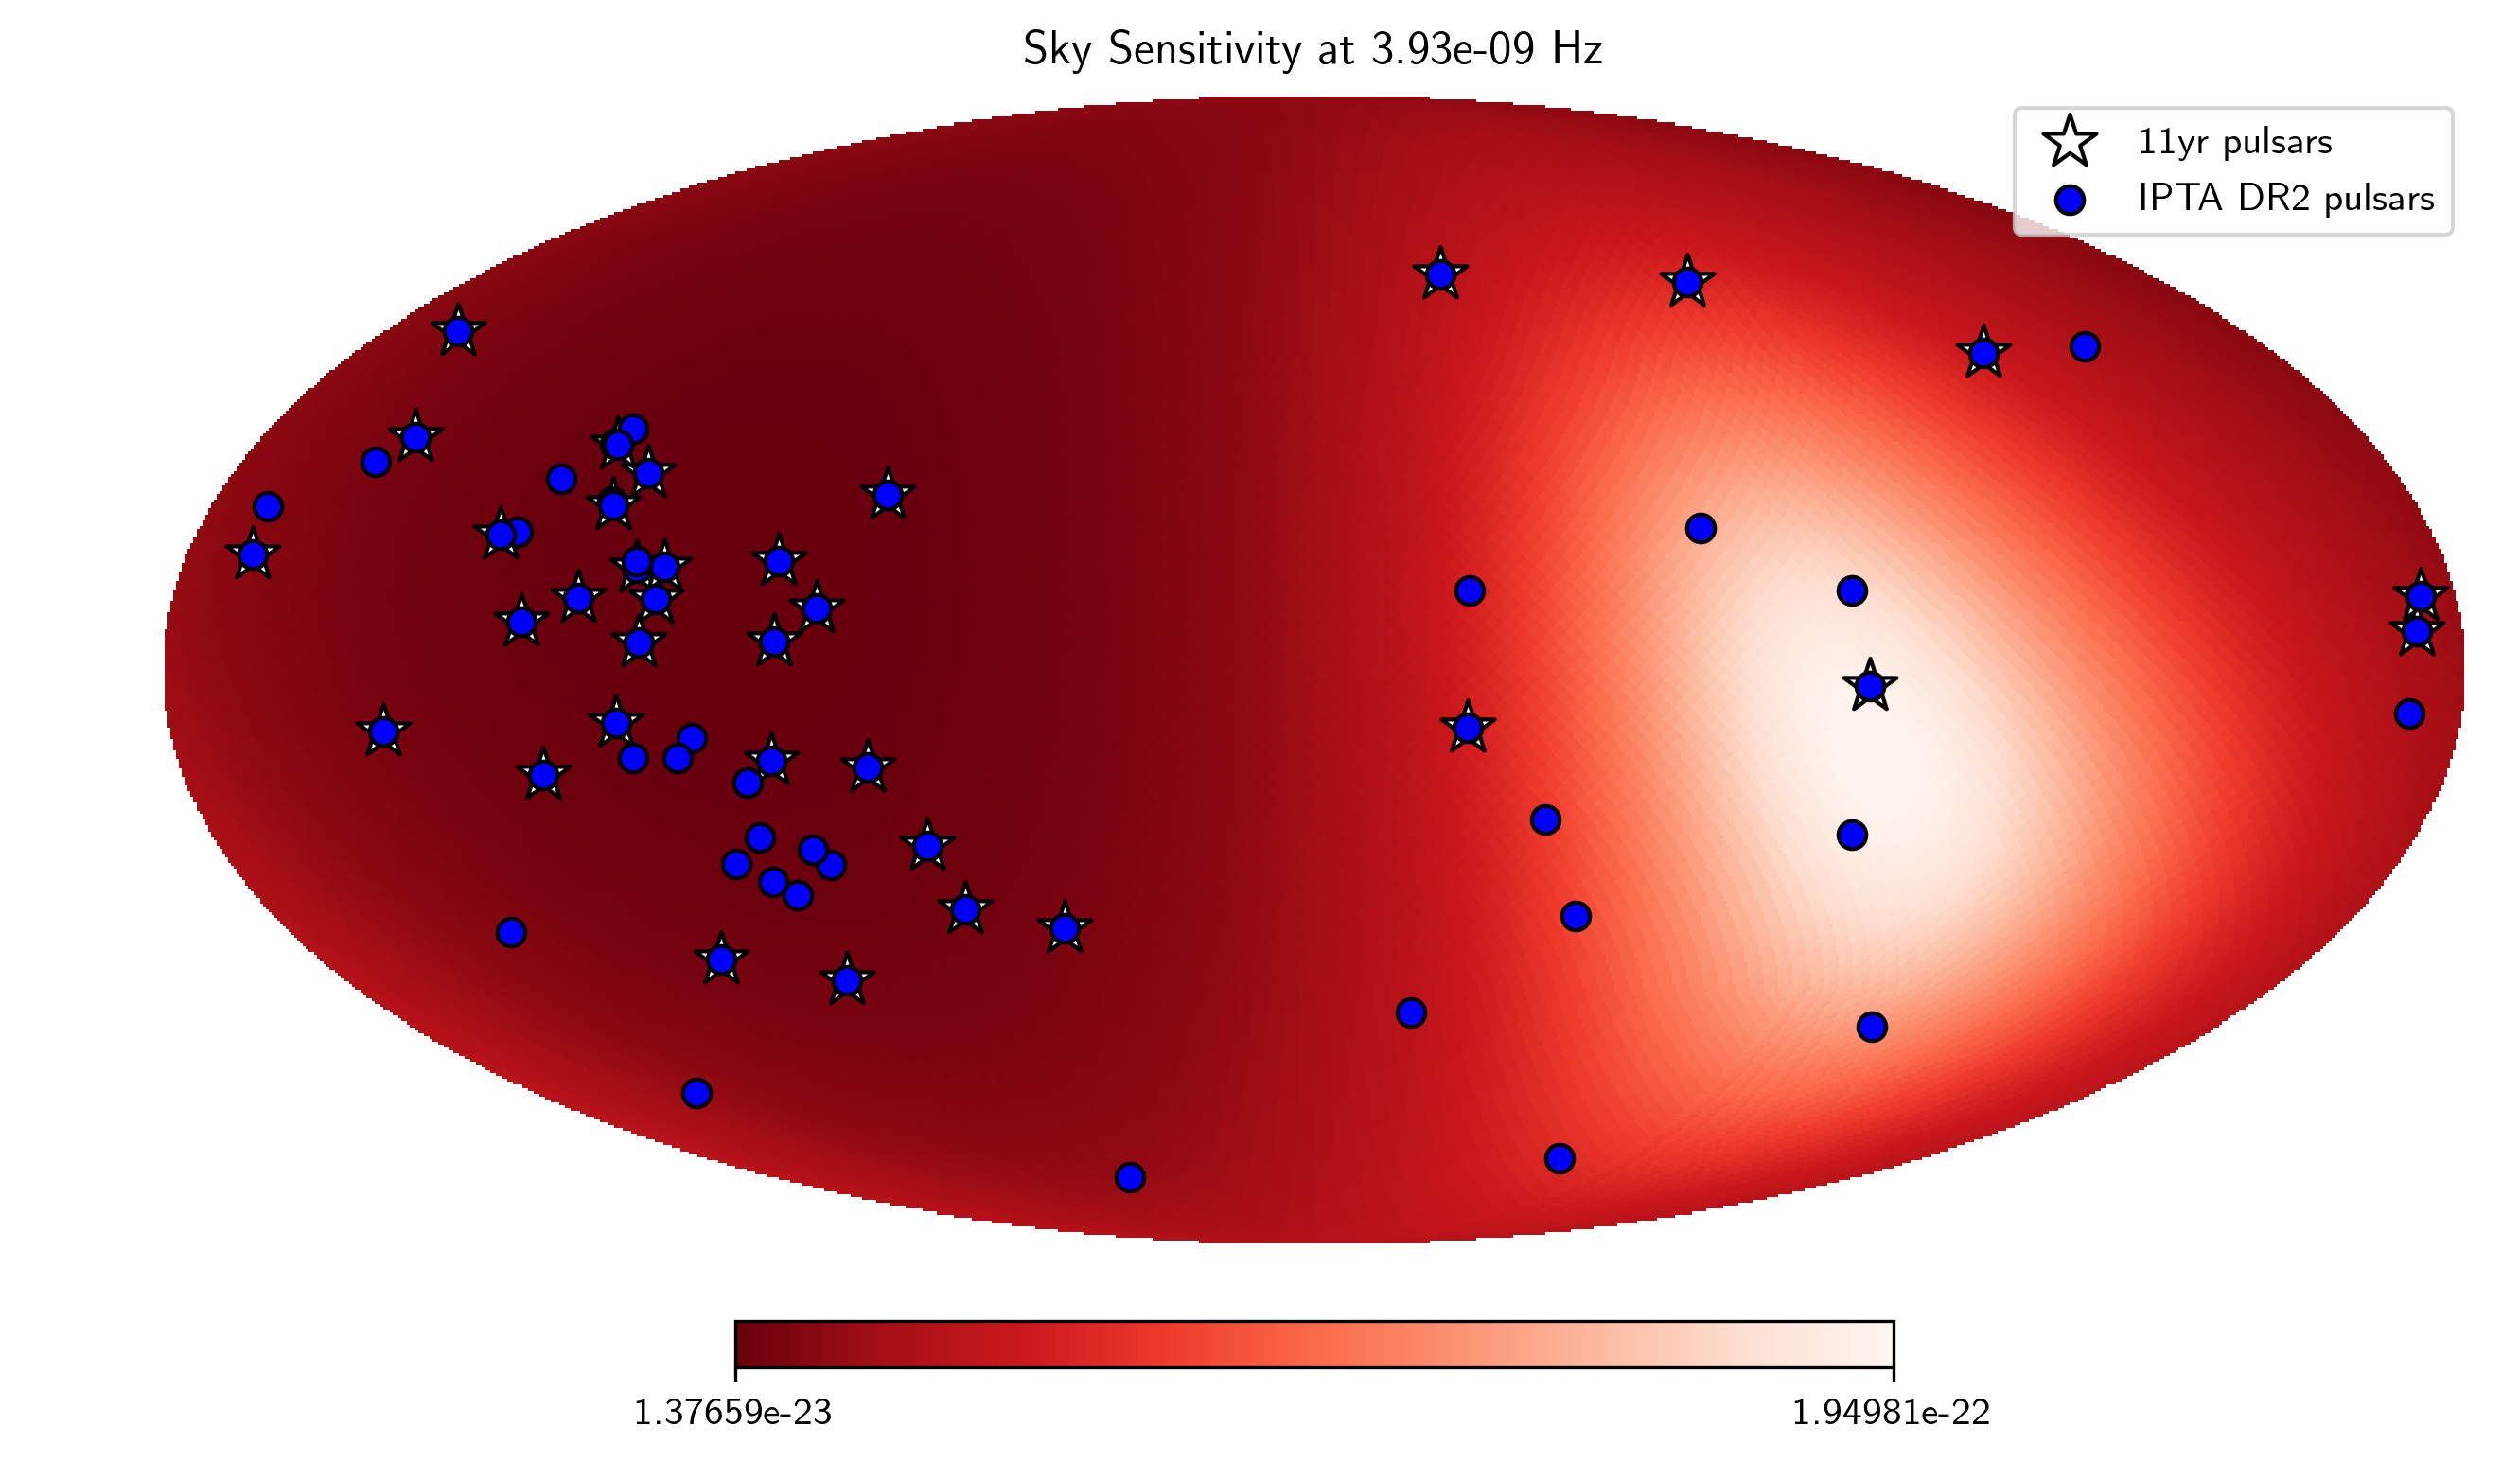

In [22]:
idxs = np.unravel_index(np.argmin(sky_map.S_effSky, axis=None), sky_map.S_effSky.shape)
idx = idxs[0]
hp.mollview(sky_map.S_effSky[idx],
            title="Sky Sensitivity at {0:2.2e} Hz".format(sky_map.freqs[idx]),
            cmap='Reds_r', rot=180)
hp.visufunc.projscatter(sky_map.thetas,sky_map.phis,
                        marker='*',color='white',
                        edgecolors='k',s=200,label='11yr pulsars')
hp.visufunc.projscatter(thetas_ipta,phis_ipta,
                        marker='.',color='blue',
                        edgecolors='k',s=200,label='IPTA DR2 pulsars')
plt.legend()
plt.show()

In [42]:
dist, xedges, yedges = np.histogram2d(phis, thetas, density=True, bins=(len(thetas),len(phis)))

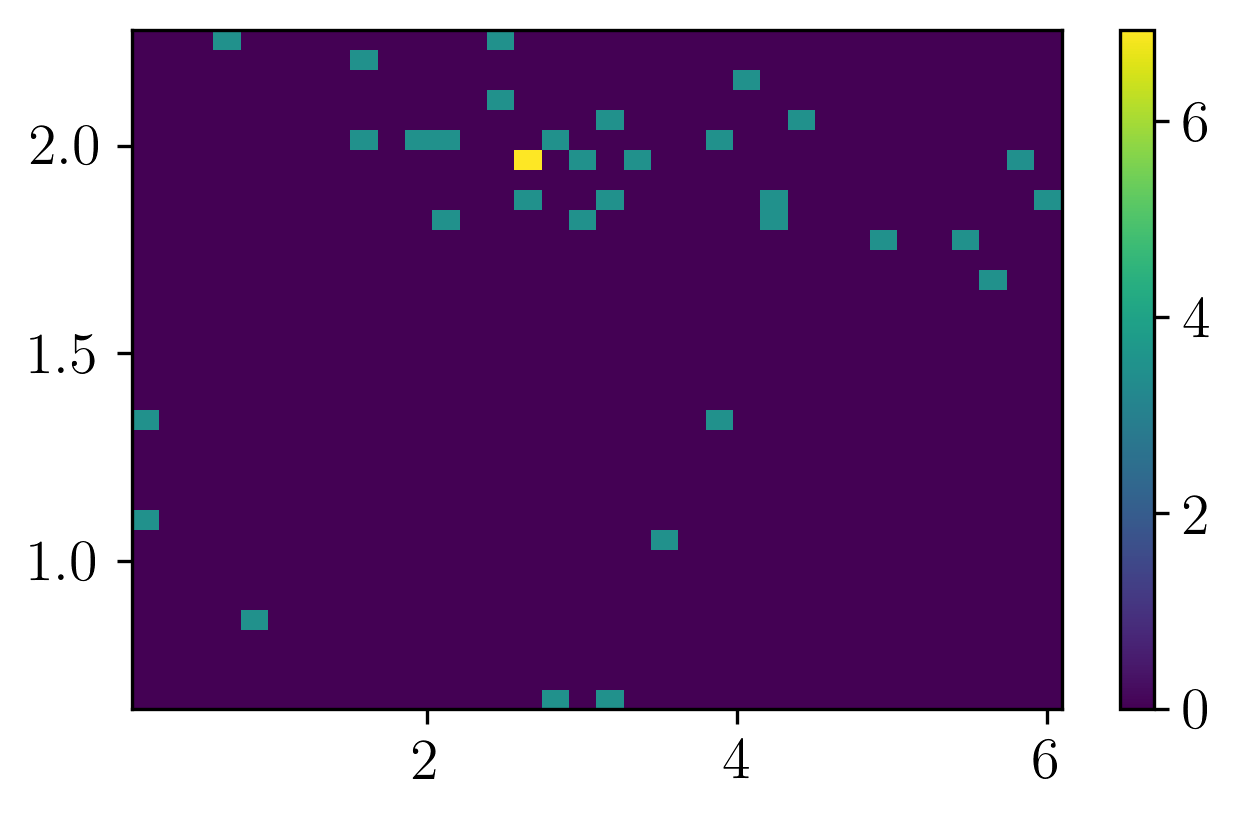

In [43]:
plt.figure()
X, Y = np.meshgrid(xedges, yedges)
c1 = plt.pcolormesh(X, Y, dist)
plt.colorbar(c1)
plt.show()

In [45]:
n_draws = 200
thetas_drawn = []
phis_drawn = []
for i in range(n_draws):
    [theta_draw,phi_draw] = emp_dist.draw()
    thetas_drawn.append(theta_draw)
    phis_drawn.append(phi_draw)
indices_drawn = hp.ang2pix(NSIDE, thetas_drawn, phis_drawn)
idx_drawn, counts_drawn = np.unique(indices_drawn, return_counts=True)

NameError: name 'emp_dist' is not defined

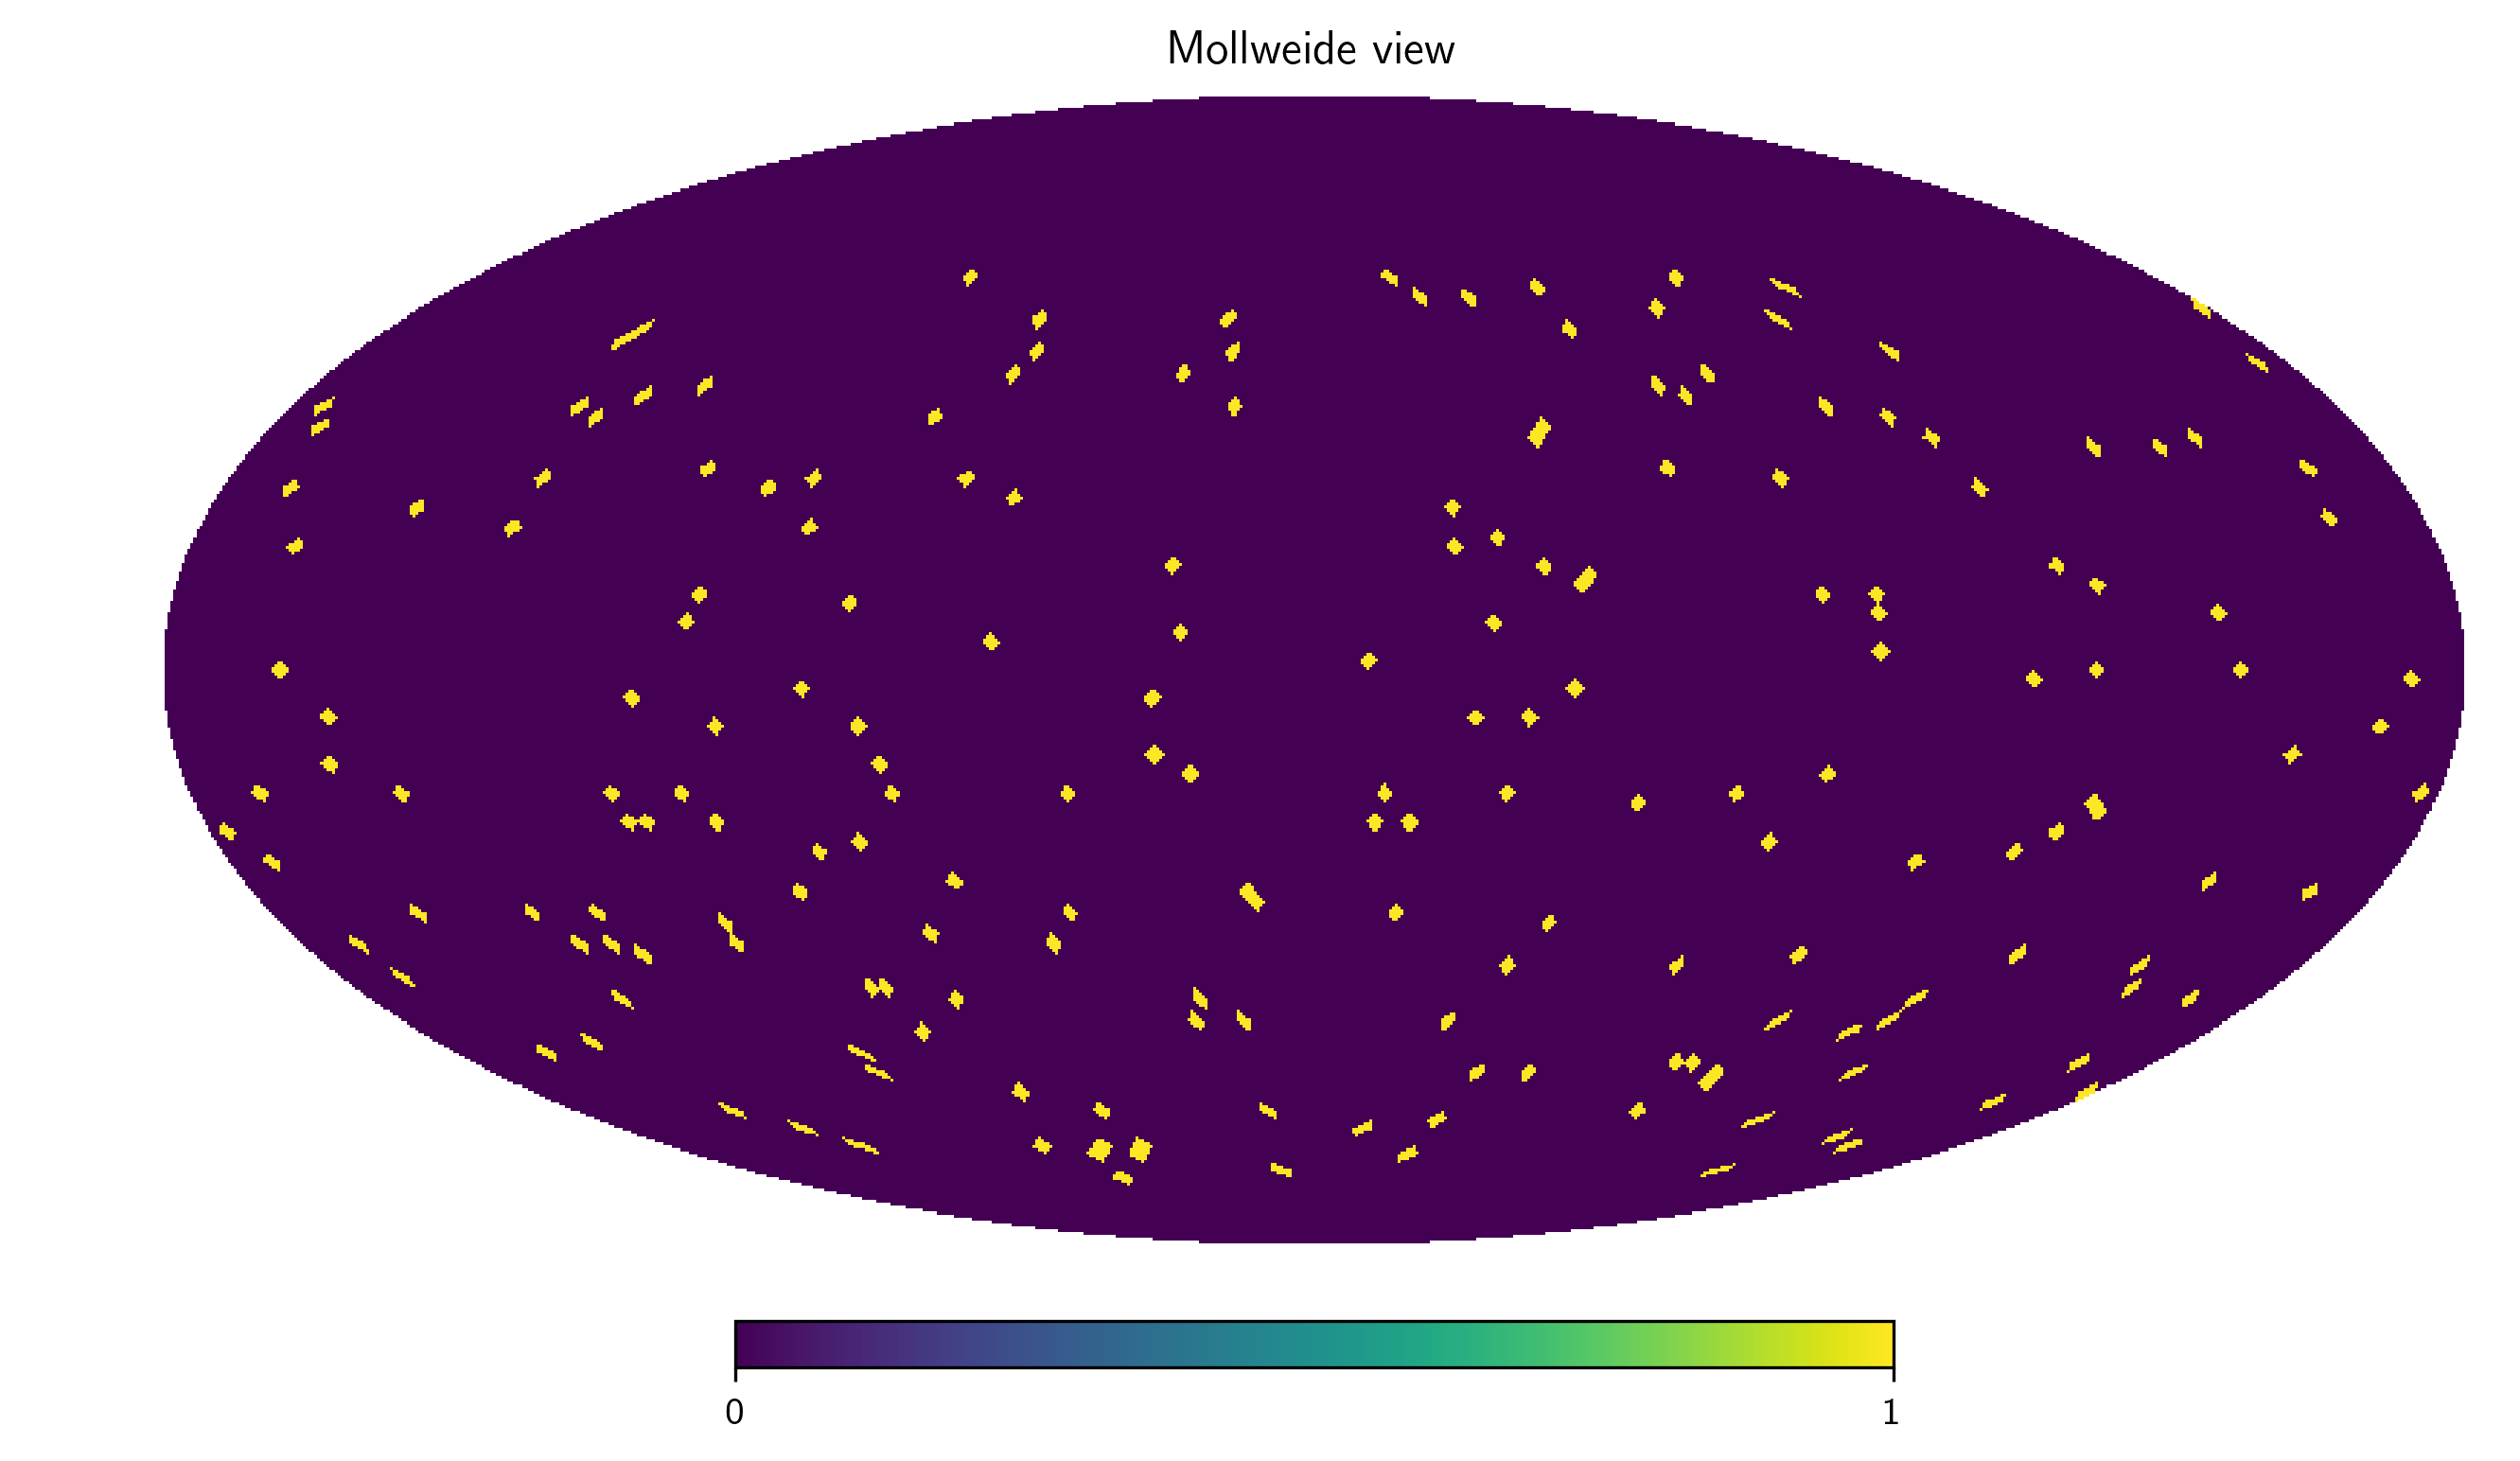

In [26]:
# fill the fullsky map
hpx_map_drawn = np.zeros(NPIX, dtype=int)
hpx_map_drawn[idx_drawn] = counts_drawn
hp.mollview(hpx_map_drawn)

In [27]:
n_draws =int(1e3)
tmp_thetas = np.linspace(0.,np.pi,n_draws)
tmp_phis = np.linspace(0.,2*np.pi,n_draws)
tmp_prob_array = np.zeros((len(tmp_thetas),len(tmp_phis)))
print(np.shape(tmp_prob_array))
for i,tmp_theta in enumerate(tmp_thetas):
    for j,tmp_phi in enumerate(tmp_phis):
        tmp_prob_array[i,j] = emp_dist.prob([tmp_theta,tmp_phi])

(1000, 1000)


In [28]:
print(min(tmp_prob_array))
print(max(tmp_prob_array))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [44]:
fig = plt.figure()
c1 = plt.contourf(tmp_thetas,tmp_phis,tmp_prob_array)
cbar = fig.colorbar(c1)

NameError: name 'tmp_thetas' is not defined

<Figure size 1500x900 with 0 Axes>

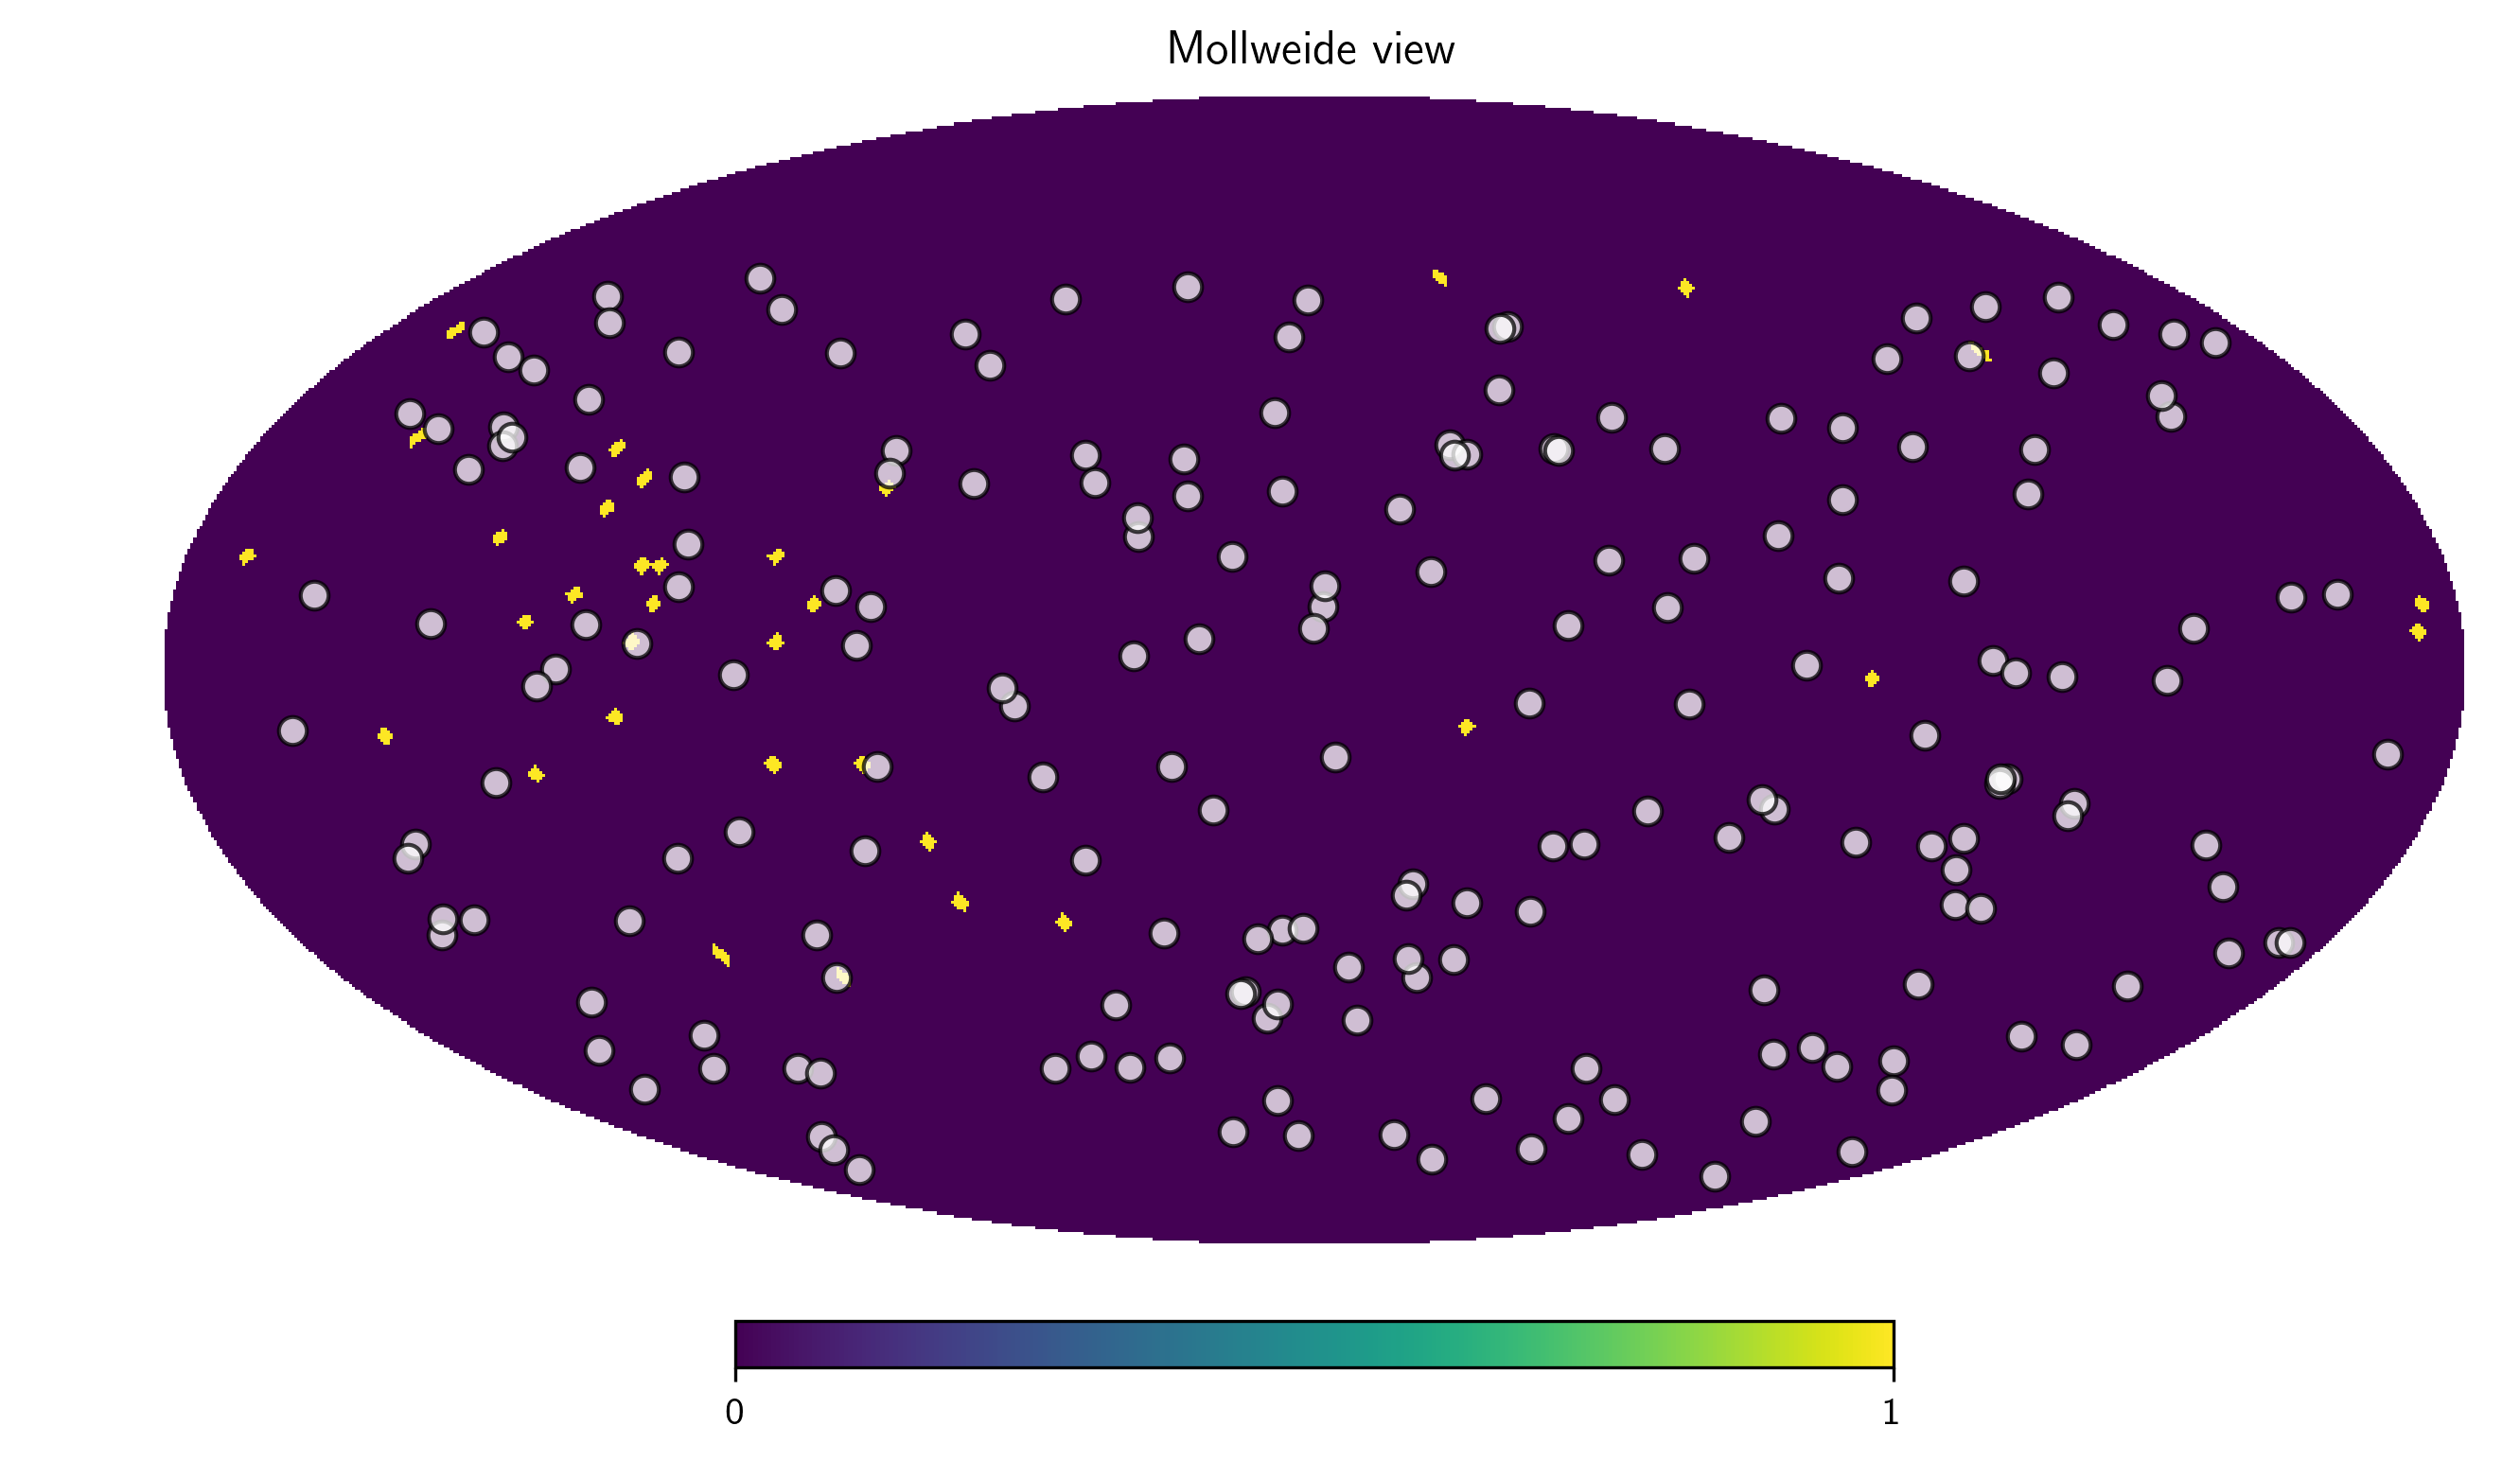

In [33]:
# convert to HEALPix indices
indices = hp.ang2pix(NSIDE, thetas, phis)

idx, counts = np.unique(indices, return_counts=True)

# fill the fullsky map
hpx_map = np.zeros(NPIX, dtype=int)
hpx_map[idx] = counts
hp.mollview(hpx_map,rot=180)
hp.visufunc.projscatter(thetas_drawn,phis_drawn,
                        marker='.',color='w',
                        edgecolors='k',s=200,label=r'Selected pulsars',alpha=.75)

In [20]:
nbins = 8
#Add non-zero probability of picking 0 and pi
new_thetas = np.append(thetas,
                       np.linspace(0.,np.pi,nbins))
new_phis = np.append(phis,
                     np.linspace(0.,2*np.pi,nbins))
#add non-zero probability in middle of alphas and amps
new_rn_alphas = np.append(rn_alphas,
                          np.linspace(min(rn_alphas),max(rn_alphas),nbins))
new_rn_amps = np.append(rn_amps,
                        np.logspace(min(np.log10(rn_amps)),max(np.log10(rn_amps)),nbins))
new_sigmas = np.append(sigmas,
                       np.linspace(min(sigmas),max(sigmas),nbins))


phi_hist = np.histogram(new_phis, bins=nbins,density=True)
theta_hist = np.histogram(new_thetas, bins=nbins,density=True)
alpha_hist = np.histogram(new_rn_alphas, bins=nbins,density=True)
rn_amp_hist = np.histogram(new_rn_amps,
                           bins=np.logspace(min(np.log10(new_rn_amps)),max(np.log10(new_rn_amps)),nbins),
                           density=True)
sigma_hist = np.histogram(new_sigmas, bins=nbins,density=True)

phi_dist = stats.rv_histogram(phi_hist)
theta_dist = stats.rv_histogram(theta_hist)
alpha_dist = stats.rv_histogram(alpha_hist)
rn_amp_dist = stats.rv_histogram(rn_amp_hist)
sigma_dist = stats.rv_histogram(sigma_hist)

In [21]:
print(np.log10(rn_amps))
print(np.log10(new_rn_amps))

[-14.4482 -13.9708 -19.1534 -13.4453 -15.7244 -17.7248 -13.4085 -16.4807
 -13.9934 -13.4112 -15.9076 -13.1482 -13.8022 -16.5822 -19.8132 -13.2382
 -19.8803 -12.6741 -12.6892 -13.88   -15.1094 -13.1801 -15.5849 -13.3622
 -13.2501 -15.8404 -12.242  -16.613  -19.5541 -12.488  -12.2396 -12.2051
 -12.8089 -13.2745]
[-14.4482     -13.9708     -19.1534     -13.4453     -15.7244
 -17.7248     -13.4085     -16.4807     -13.9934     -13.4112
 -15.9076     -13.1482     -13.8022     -16.5822     -19.8132
 -13.2382     -19.8803     -12.6741     -12.6892     -13.88
 -15.1094     -13.1801     -15.5849     -13.3622     -13.2501
 -15.8404     -12.242      -16.613      -19.5541     -12.488
 -12.2396     -12.2051     -12.8089     -13.2745     -19.8803
 -18.78384286 -17.68738571 -16.59092857 -15.49447143 -14.39801429
 -13.30155714 -12.2051    ]


In [22]:
t = np.linspace(0,np.pi,50)
p = np.linspace(0,2*np.pi,50)
a = np.linspace(min(rn_alphas),max(rn_alphas),50)
r = np.logspace(min(np.log10(rn_amps)),max(np.log10(rn_amps)),50)
sigmas_plt = sigmas/u.us.to('s')
s = np.linspace(min(sigmas_plt),max(sigmas_plt),50)

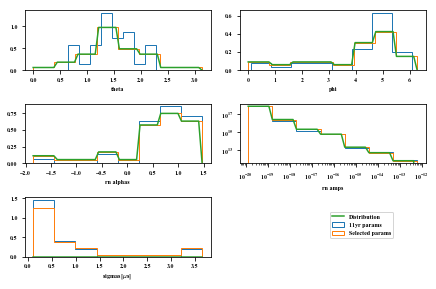

In [23]:
mpl.rc('font',**{'family':'serif','serif':['Times New Roman'],'size':6})
fig,axes = plt.subplots(3,2)
fig.delaxes(axes[2,1])
axes[0,0].hist(thetas, histtype='step', density= True, bins=nbins,label=r'11yr params')
axes[0,0].hist(new_thetas, histtype='step', density= True, bins=nbins,label=r'Selected params')
axes[0,0].plot(t,theta_dist.pdf(t),label=r'Distribution')
axes[0,0].set_xlabel(r'theta')

axes[0,1].hist(phis, histtype='step', density= True, bins=nbins,label=r'11yr params')
axes[0,1].hist(new_phis, histtype='step', density= True, bins=nbins,label=r'Selected params')
axes[0,1].plot(p,phi_dist.pdf(p),label=r'Distribution')
axes[0,1].set_xlabel(r'phi')

sigmas_plt = sigmas/u.us.to('s')
new_sigmas_plt = new_sigmas/u.us.to('s')
sigma_dist_plt = sigma_dist.pdf(s)/u.us.to('s')
axes[2,0].hist(sigmas_plt, histtype='step', density= True,
         bins=nbins,label=r'11yr params')
axes[2,0].hist(new_sigmas_plt, histtype='step', density= True,
         bins=nbins,label=r'Selected params')
axes[2,0].plot(s,sigma_dist_plt,label=r'Distribution')
axes[2,0].set_xlabel(r'sigmas [$\mu$s]')

axes[1,0].hist(rn_alphas, histtype='step', density= True, bins=nbins,label=r'11yr params')
axes[1,0].hist(new_rn_alphas, histtype='step', density= True, bins=nbins,label=r'Selected params')
axes[1,0].plot(a,alpha_dist.pdf(a),label=r'Distribution')
axes[1,0].set_xlabel(r'rn alphas')

axes[1,1].hist(rn_amps, histtype='step', density= True,
         bins=np.logspace(min(np.log10(rn_amps)),max(np.log10(rn_amps)),nbins),label=r'11yr params')
axes[1,1].hist(new_rn_amps, histtype='step', density= True,
         bins=np.logspace(min(np.log10(new_rn_amps)),max(np.log10(new_rn_amps)),nbins),label=r'Selected params')
axes[1,1].plot(r,rn_amp_dist.pdf(r),label=r'Distribution')
axes[1,1].set_yscale('log')
axes[1,1].set_xscale('log')
axes[1,1].set_xlabel(r'rn amps')
fig.tight_layout()
plt.legend(bbox_to_anchor=(2, .8))
plt.savefig(save_dir+'noise_distributions.png',bbox_inches='tight')
plt.show()

In [24]:
N_p = 200
theta_draws_1 = theta_dist.rvs(size=N_p)
phi_draws_1 = phi_dist.rvs(size=N_p)
rn_amp_draws_1 = rn_amp_dist.rvs(size=N_p)
rn_alpha_draws_1 = alpha_dist.rvs(size=N_p)
sigma_draws_1 = sigma_dist.rvs(size=N_p)

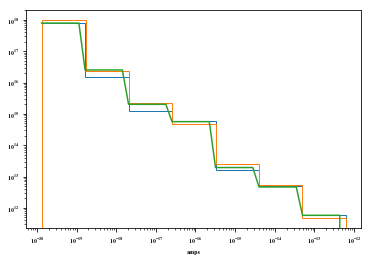

In [25]:
plt.figure()
plt.hist(rn_amps, histtype='step', density= True,
         bins=np.logspace(min(np.log10(rn_amps)),max(np.log10(rn_amps)),nbins))
plt.hist(rn_amp_draws_1, histtype='step', density= True,
         bins=np.logspace(min(np.log10(rn_amp_draws_1)),max(np.log10(rn_amp_draws_1)),nbins))
plt.plot(r,rn_amp_dist.pdf(r))
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'amps')
plt.show()

In [26]:
mpl.rc('font',**{'family':'serif','serif':['Times New Roman'],'size':14})

In [27]:
new_sky_map = make_hasasia_sensitivity_thing(T_obs,cadence,
                                             sigma_draws_1,phi_draws_1,
                                             theta_draws_1,rn_amp_draws_1,
                                             rn_alpha_draws_1)

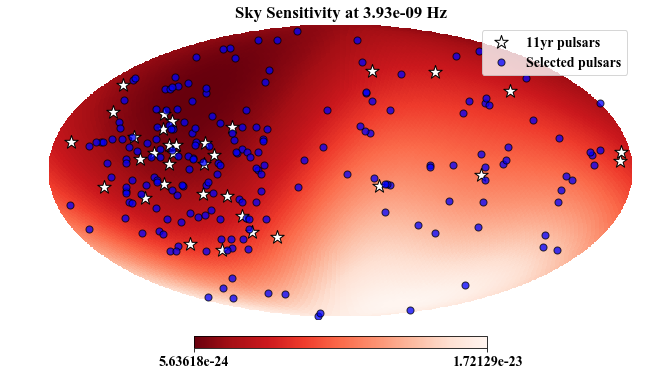

In [28]:
idxs = np.unravel_index(np.argmin(new_sky_map.S_effSky, axis=None), new_sky_map.S_effSky.shape)
idx = idxs[0]
hp.mollview(new_sky_map.S_effSky[idx],
            title="Sky Sensitivity at {0:2.2e} Hz".format(new_sky_map.freqs[idx]),
            cmap='Reds_r', rot=180)
hp.visufunc.projscatter(sky_map.thetas,sky_map.phis,
                        marker='*',color='white',
                        edgecolors='k',s=200,label=r'11yr pulsars')
hp.visufunc.projscatter(new_sky_map.thetas,new_sky_map.phis,
                        marker='.',color='blue',
                        edgecolors='k',s=200,label=r'Selected pulsars',alpha=.75)
plt.legend()
plt.savefig(save_dir+'drawn_PTA.png')
plt.show()

In [29]:
N_p = 14
if N_p > len(noise_11yr):
    N_added_p = N_p - len(noise_11yr)
    theta_draws = theta_dist.rvs(size=N_added_p)
    phi_draws = phi_dist.rvs(size=N_added_p)
    rn_amp_draws = rn_amp_dist.rvs(size=N_added_p)
    alpha_draws = alpha_dist.rvs(size=N_added_p)
    sigma_draws = sigma_dist.rvs(size=N_added_p)
    
    new_added_thetas = np.append(thetas,theta_draws)
    new_added_phis = np.append(phis,phi_draws)
    new_added_rn_amps = np.append(rn_amps,rn_amp_draws)
    new_added_alphas = np.append(rn_alphas,alpha_draws)
    new_added_sigmas = np.append(sigmas,sigma_draws)
else:
    new_added_thetas = thetas[:N_p]
    new_added_phis = phis[:N_p]
    new_added_rn_amps = rn_amps[:N_p]
    new_added_rn_alphas = rn_alphas[:N_p]
    new_added_sigmas = sigmas[:N_p]

In [30]:
new_added_sky_map = make_hasasia_sensitivity_thing(T_obs,cadence,
                                                   new_added_sigmas,new_added_phis,
                                                   new_added_thetas,new_added_rn_amps,
                                                   new_added_rn_alphas)

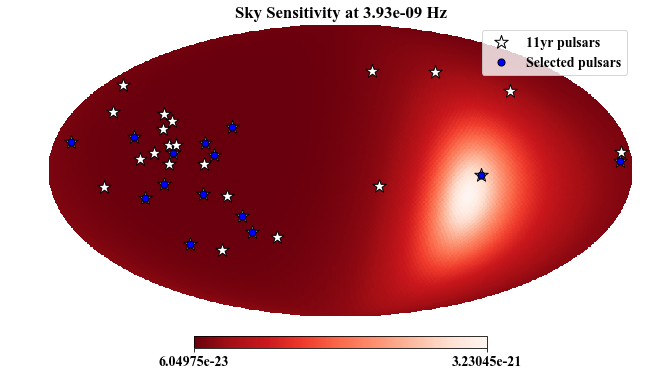

In [31]:
idxs = np.unravel_index(np.argmin(new_added_sky_map.S_effSky, axis=None),
                        new_added_sky_map.S_effSky.shape)
idx = idxs[0]
hp.mollview(new_added_sky_map.S_effSky[idx],
            title="Sky Sensitivity at {0:2.2e} Hz".format(new_added_sky_map.freqs[idx]),
            cmap='Reds_r', rot=180)
hp.visufunc.projscatter(sky_map.thetas,sky_map.phis,
                        marker='*',color='white',
                        edgecolors='k',s=200,label=r'11yr pulsars')
hp.visufunc.projscatter(new_added_sky_map.thetas,new_added_sky_map.phis,
                        marker='.',color='blue',
                        edgecolors='k',s=200,label=r'Selected pulsars')
plt.legend()
plt.show()

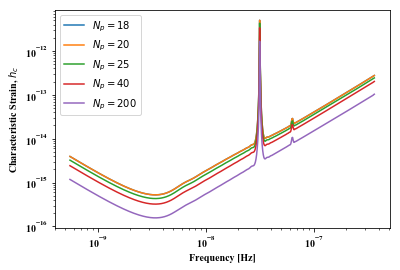

In [32]:
mpl.rc('font',**{'family':'serif','serif':['Times New Roman'],'size':10})
N_ps = [18,20,25,40,200]
plt.figure()
for N_p in N_ps:
    if N_p > len(noise_11yr):
        N_added_p = N_p - len(noise_11yr)
        theta_draws = theta_dist.rvs(size=N_added_p)
        phi_draws = phi_dist.rvs(size=N_added_p)
        rn_amp_draws = rn_amp_dist.rvs(size=N_added_p)
        alpha_draws = alpha_dist.rvs(size=N_added_p)
        sigma_draws = sigma_dist.rvs(size=N_added_p)

        new_added_thetas = np.append(thetas,theta_draws)
        new_added_phis = np.append(phis,phi_draws)
        new_added_rn_amps = np.append(rn_amps,rn_amp_draws)
        new_added_rn_alphas = np.append(rn_alphas,alpha_draws)
        new_added_sigmas = np.append(sigmas,sigma_draws)
    else:
        new_added_thetas = thetas[:N_p]
        new_added_phis = phis[:N_p]
        new_added_rn_amps = rn_amps[:N_p]
        new_added_rn_alphas = rn_alphas[:N_p]
        new_added_sigmas = sigmas[:N_p]

    pta = make_hasasia_sensitivity_thing(T_obs,cadence,
                                         new_added_sigmas,new_added_phis,
                                         new_added_thetas,new_added_rn_amps,
                                         new_added_rn_alphas,SkyAvg=True)
    plt.loglog(pta.freqs,pta.h_c,label=r'$N_{p} = %i$' %N_p)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.legend()
plt.savefig(save_dir+'drawn_PTA_sens_curves.png',bbox_inches='tight')
plt.show()